In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import yfinance as yf

In [2]:
# Download historical stock price data (e.g., Apple)
df = yf.download('AAPL', start='2015-01-01', end='2023-01-01')
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373962,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687307,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689533,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021717,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944689,237458000


In [3]:
# Use 'Close' prices for prediction
data = df['Close'].values
data = data.reshape(-1, 1)

# Scale the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create training data
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create a function to process the data
def create_dataset(dataset, time_step=100):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Prepare the data
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [5]:
from keras.layers import Input

# Build the LSTM model with an explicit Input layer
model = Sequential()
model.add(Input(shape=(time_step, 1)))  # Explicitly define the input shape
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [6]:
# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 0.0253
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0013
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 4.7297e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 3.4032e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 3.6070e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 3.1425e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - loss: 3.2072e-04
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 268ms/step - loss: 3.6934e-04
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - loss: 3.1824e-04
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - loss: 2.7951e-04
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 2.8132e-04
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - loss: 3.0998e-04
Epoch 13/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 3.0739e-04
Epoch 14/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 2.8732e-04
Epoch 15/50
24/

In [7]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual prices
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


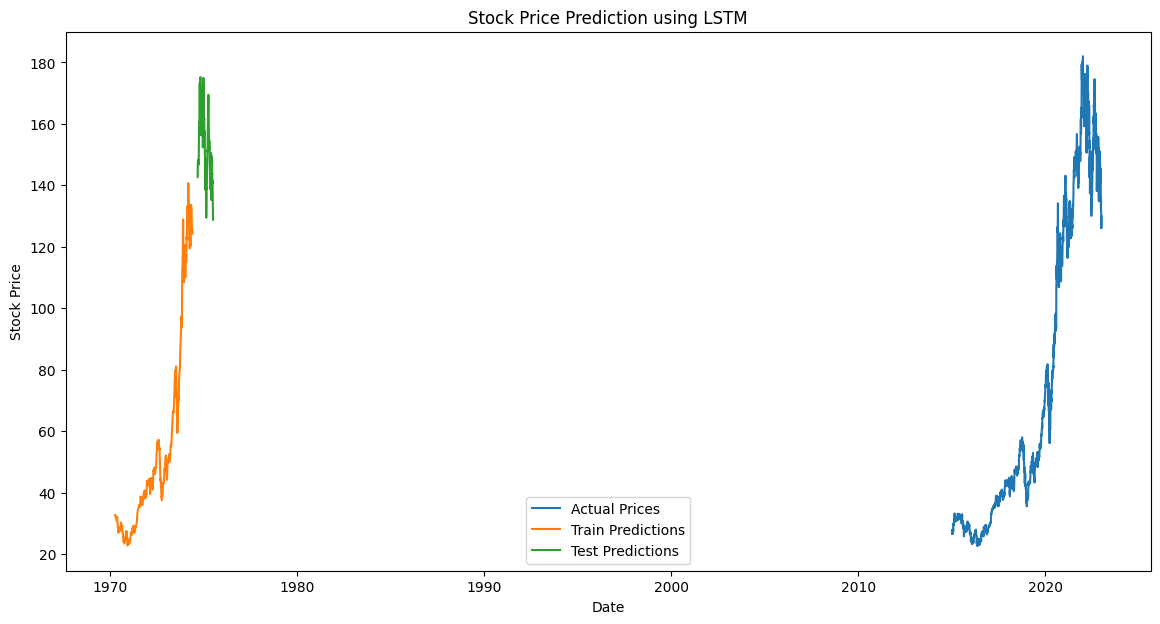

In [8]:
# Plot the results
plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Actual Prices')
plt.plot(np.arange(time_step, time_step + len(train_predict)), train_predict, label='Train Predictions')
plt.plot(np.arange(len(train_data) + time_step, len(scaled_data) - 1), test_predict, label='Test Predictions')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()